In [24]:
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.signal import stft
import seaborn as sns
from os import listdir
import os.path as op
import glob
import pickle
import mne
from mne import Info
sns.set()

In [25]:
def ERD_MEAN(exp_name):
    
    electrodes_list = ['EEG Fp1-Cz', 'EEG Fp2-Cz', 'EEG F3-Cz', 'EEG F4-Cz', 'EEG F7-Cz', 'EEG F8-Cz']
    
    raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)
    raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)
    sfreq = raw_exp.info['sfreq']

    # Data from specific channels
    eyes = raw_cal.copy().pick_channels(ch_names=electrodes_list);
    experiment = raw_exp.copy().pick_channels(ch_names=electrodes_list)

    # Filtering AC line noise with notch filter

    # eyes_filtered_data = mne.filter.notch_filter(x=eyes.get_data(), Fs=sfreq, freqs=[50, 100])
    # experiment_filtered_data = mne.filter.notch_filter(x=experiment.get_data(), Fs=sfreq, freqs=[50, 100])
    eyes_filtered_data = eyes.get_data()
    experiment_filtered_data = experiment.get_data()

    # Preparing data for plotting
    eyes_filtered = mne.io.RawArray(data=eyes_filtered_data,
                                    info=mne.create_info(ch_names=electrodes_list, sfreq=sfreq))
    experiment_filtered = mne.io.RawArray(data=experiment_filtered_data,
                                          info=mne.create_info(ch_names=electrodes_list, sfreq=sfreq))

    IAF_p = IAF(20)

    # Getting L1A, L2A, UA, Theta waves from eyes closed using FIR filtering. Also we take mean signal from all channels
    eyes_sub_bands = {}

    eyes_sub_bands['L1A'] = mne.filter.filter_data(data=np.mean(eyes_filtered.get_data(), axis=0), l_freq=IAF_p - 4,
                                                   h_freq=IAF_p - 2, sfreq=sfreq, method="fir")
    eyes_sub_bands['L2A'] = mne.filter.filter_data(data=np.mean(eyes_filtered.get_data(), axis=0), l_freq=IAF_p - 2,
                                                   h_freq=IAF_p, sfreq=sfreq, method="fir")
    

    # Getting L1A, L2A, UA, Theta waves from experiment data using FIR filtering. Also we take mean signal from all
    # channels
    experiment_sub_bands = {}

    experiment_sub_bands['L1A'] = mne.filter.filter_data(data=np.mean(experiment_filtered.get_data(), axis=0),
                                                         l_freq=IAF_p - 4, h_freq=IAF_p - 2, sfreq=sfreq, method="fir")
    experiment_sub_bands['L2A'] = mne.filter.filter_data(data=np.mean(experiment_filtered.get_data(), axis=0),
                                                         l_freq=IAF_p - 2, h_freq=IAF_p, sfreq=sfreq, method="fir")
    

    # Calculating calibration values. Consider mean value of all channels. Va;ue are given in microvolts
    calibration_values = {}

    for band in eyes_sub_bands:
        calibration_values[band] = np.mean(eyes_sub_bands[band], axis=0) * np.power(10, 6)

    # Performing STFT transform on experiment data for each sub-band. Window size is given in samples
    window = sfreq * 2
    fft = {}

    for band in experiment_sub_bands:
        fft[band] = stft(x=experiment_sub_bands[band], fs=sfreq, window=('kaiser', window), nperseg=1000)

    erd = np.vectorize(ERD)
    # Calculating ERD for experiment
    erd_mean = {}
    erd_all = {}

    for band in fft:
        erd_all[band] = erd(fft[band][2], calibration_values[band])
        erd_mean[band] = np.mean(erd_all[band], axis=0)
    
    return erd_mean

In [26]:
def get_experiments_mean(load_dir):
    
    ERD_MEANS = []
    directories = listdir(load_dir)

    for directory in directories:
        
        path = os.path.join(load_dir, directory)
        cal_name = glob.glob(path+'\*Calibration.Opened.edf')
        exp_name1 = glob.glob(path+'\*.Data1.edf')
        exp_name2 = glob.glob(path+'\*.Data2.edf')

        erd_mean1 = ERD_MEAN(exp_name1)
        erd_mean2 = ERD_MEAN(exp_name2)
        data1_All_mean = (np.mean(erd_mean1['L1A']) +np.mean(erd_mean1['L2A'])) / 2
        data2_All_mean = (np.mean(erd_mean2['L1A']) +np.mean(erd_mean2['L2A'])) / 2
        ERD_MEANS.append((data1_All_mean + data2_All_mean)/2)
    
    return ERD_MEANS

In [35]:
def print_results(ERD_MEANS, exp_name):
    
    print('\n\n')
    print('----------------------- ' + exp_name +  ' DATA MEAN -----------------------\n')
    print('ERD MEAN FOR WHOLE DATA: ' + str(np.mean(ERD_MEANS)))
    print('\n\n')

    plt.xlabel(exp_name + '-Experiments')
    plt.ylabel('Mean ERD')
    plt.plot(np.real(ERD_MEANS))
    plt.show()
    plt.savefig(obg_dir + '.png', dpi=100)
    

Extracting EDF parameters from D:\LIPS EEG EXPERIMENTS\DATA WITHOUT ARTIFACTS\Control\Zuhair.Control.3\ZuhairAbbas.20190531.Control.Calibration.Opened.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 72499  =      0.000 ...   289.996 secs...
Extracting EDF parameters from D:\LIPS EEG EXPERIMENTS\DATA WITHOUT ARTIFACTS\Control\Yekaterina.Control.1\YekaterinaPakhtusova.20190523.Control.Data1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274999  =      0.000 ...  1099.996 secs...


<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=275000
    Range : 0 ... 274999 =      0.000 ...  1099.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:6: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)


Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.89
- Lower transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 7.78 Hz)
- Upper passband edge: 10.89 Hz
- Upper transition bandwidth: 2.72 Hz (-6 dB cutoff frequency: 12.25 Hz)


<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)
<ipython-input-25-6701fa62eccc>:6: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=523750
    Range : 0 ... 523749 =      0.000 ...  2094.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=446750
    Range : 0 ... 446749 =      0.000 ...  1786.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=465000
    Range : 0 ... 464999 =      0.000 ...  1859.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=387750
    Range : 0 ... 387749 =      0.000 ...  1550.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)
<ipython-input-25-6701fa62eccc>:6: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=405750
    Range : 0 ... 405749 =      0.000 ...  1622.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=486750
    Range : 0 ... 486749 =      0.000 ...  1946.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=521250
    Range : 0 ... 521249 =      0.000 ...  2084.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=557250
    Range : 0 ... 557249 =      0.000 ...  2228.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=576000
    Range : 0 ... 575999 =      0.000 ...  2303.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=545750
    Range : 0 ... 545749 =      0.000 ...  2182.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=505500
    Range : 0 ... 505499 =      0.000 ...  2021.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=475000
    Range : 0 ... 474999 =      0.000 ...  1899.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=427250
    Range : 0 ... 427249 =      0.000 ...  1708.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=466250
    Range : 0 ... 466249 =      0.000 ...  1864.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=443250
    Range : 0 ... 443249 =      0.000 ...  1772.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=427500
    Range : 0 ... 427499 =      0.000 ...  1709.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=445250
    Range : 0 ... 445249 =      0.000 ...  1780.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=400000
    Range : 0 ... 399999 =      0.000 ...  1599.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)
<ipython-input-25-6701fa62eccc>:6: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=396500
    Range : 0 ... 396499 =      0.000 ...  1585.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=623750
    Range : 0 ... 623749 =      0.000 ...  2494.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)
<ipython-input-25-6701fa62eccc>:6: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw_exp = mne.io.read_raw_edf(exp_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=633750
    Range : 0 ... 633749 =      0.000 ...  2534.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=604250
    Range : 0 ... 604249 =      0.000 ...  2416.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

<ipython-input-25-6701fa62eccc>:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cal = mne.io.read_raw_edf(cal_name[0], preload=True)


Creating RawArray with float64 data, n_channels=6, n_times=72500
    Range : 0 ... 72499 =      0.000 ...   289.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=552500
    Range : 0 ... 552499 =      0.000 ...  2209.996 secs
Ready.
Setting up band-pass filter from 6.9 - 8.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.89
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.89 Hz)
- Upper passband edge: 8.89 Hz
- Upper transition bandwidth: 2.22 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-pass filter from 8.9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

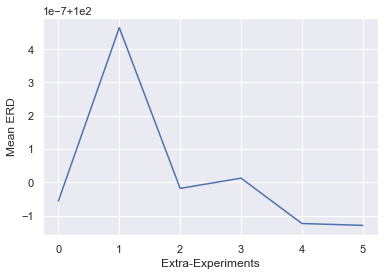




-------------------- CONTROL DATA MEAN --------------------

ERD MEAN FOR WHOLE DATA: (99.9999995247701-8.28526434253776e-09j)





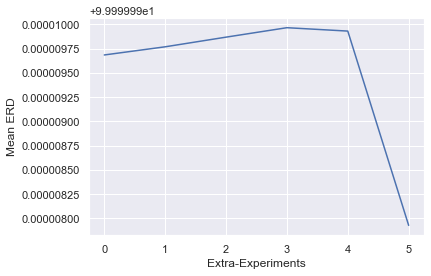

<Figure size 432x288 with 0 Axes>

In [33]:
# Function to calculate IAF
def IAF(age):
    return 11.95 - 0.053 * age


# Implementing function to calculate ERD
def ERD(f, cal):
    return 100 * (cal - f) / cal


load_dir_control = os.path.abspath(r'D:\\LIPS EEG EXPERIMENTS\\DATA WITHOUT ARTIFACTS\\Control')
load_dir_extra = os.path.abspath(r'D:\\LIPS EEG EXPERIMENTS\\DATA WITHOUT ARTIFACTS\\Extra')
obg_dir = os.path.abspath(r'D:\\LIPS EEG EXPERIMENTS\\DATA WITHOUT ARTIFACTS\\Dumps')

ERD_MEANS_CONTROL = get_experiments_mean(load_dir_control)   
ERD_MEANS_EXTRA = get_experiments_mean(load_dir_extra)    

print_results(ERD_MEANS_CONTROL)
print_results(ERD_MEANS_EXTRA)